### 👨‍🏭 Albertus Septian Angkuw

#### Pembuatan Call Graph

In [1]:
%pip install pycg

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# currentPath = input("")
currentPath = "/home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16"
print('Current Path set:' ,currentPath)

Current Path set: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16


In [3]:
import os
def walkTroughFolder(folderSC,filterExt='.py'):
    listFile = []
    for file in os.listdir(f'{currentPath}/{folderSC}'):
        if os.path.isdir(f'{currentPath}/{folderSC}/{file}'):
            listFile += walkTroughFolder(f'{folderSC}/{file}')
        elif file.endswith(filterExt):
            #print(os.path.join(f'/{folderSC}', file))
            listFile.append(os.path.join(f'/{folderSC}', file))
    return listFile

In [4]:
import time
def scanPyCG(currentPath,package):
    timestamp = int(time.time())
    targetFile = f'py_files=$(find {currentPath}/{package} -type f -name "*.py")'
    execute = f'pycg --package {package} $py_files -o {currentPath}/{package}-{timestamp}.json '
    os.system(f'{targetFile} && {execute}')
    return f'{currentPath}/{package}-{timestamp}.json'

In [5]:
print(f'Total py Files "Odoo": {len(walkTroughFolder("odoo"))} Files "Addons": {len(walkTroughFolder("addons"))} ')

Total py Files "Odoo": 412 Files "Addons": 4853 


In [6]:
# addonsJSON = scanPyCG(currentPath,f'{folderSC}/addons')
# odooJSON = scanPyCG(currentPath,f'{folderSC}/odoo')

In [7]:
addonsJSON = f'{currentPath}/odooOnlyAddonsNoPackage.json'
odooJSON = f'{currentPath}/odooCoreNoPackage.json'

#### Pembacaan Hasil Call Graph JSON

In [8]:
import json
def loadJSON(path):
   return json.load(open(path))

In [9]:
cgAddonsSource =loadJSON(addonsJSON)
cgOdooSource =loadJSON(odooJSON)
print(list(cgAddonsSource.values())[:5])
print(list(cgOdooSource.values())[:5])

[[], [], ['odoo.api.depends'], ['odoo.fields.Date.today', 'odoo.models.Model.product_id.with_company', 'odoo.models.Model.browse', '<builtin>.super'], []]
[[], [], [], ['odoo.fields.Char'], []]


In [10]:
print(len(cgOdooSource))
print(len(cgAddonsSource))

5586
24931


In [11]:
def getListRootPackage(path):
    listRootPackage = []
    for file in os.listdir(f'{path}'):
        if os.path.isdir(f'{path}/{file}'):
            listRootPackage.append(file)
        elif file.endswith('.py'):
            listRootPackage.append('.'.join(file.split(".")[:-1]))
    return listRootPackage

In [12]:
def addPrefixFolder(cg,root,listPackage):
    def checkParent(key):
        parentkey = key.split('.')[0]
        if parentkey in listPackage:
            key = f'{root}.{key}'
        return key
    newCG = {}
    for key, relation in cg.items():
        key = checkParent(key)
        if key not in newCG:
            newCG[key] = []
        for i in relation:
            newRelKey = checkParent(i)
            newCG[key].append(newRelKey)
    return newCG

In [13]:
listPackageOdoo = getListRootPackage(f'{currentPath}/odoo')
listPackageAddons = getListRootPackage(f'{currentPath}/addons')

In [14]:
cgOdoo = addPrefixFolder(cgOdooSource,"odoo",listPackageOdoo)
cgAddons = addPrefixFolder(cgAddonsSource,"addons",listPackageAddons)

In [15]:
cgSource = {}
for key, rel in cgOdoo.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
    cgSource[key] = cgSource[key] + rel

for key, rel in cgAddons.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
    cgSource[key] = cgSource[key] + rel

In [16]:
len(cgSource)

29821

#### Call Graph Raw

In [17]:
callGraphRaw = {}
for key, value in cgSource.items():
    callGraphRaw[key] = {}
    for v in value:
        callGraphRaw[key][v] = 1

In [18]:
# buatGraphviz(graph=callGraphRaw,filename=f'{folderSC}-RAW-CG')

#### Filter Call diluar Project

In [19]:
# callGraphFiltered = {}
# listRootFolder = [ 'odoo', 'addons']
# edgeGraph = []
# outsideCall = set()
# for key, value in cgSource.items():
#     rootSource = key.split('.')[0]
#     if rootSource not in listRootFolder:
#         outsideCall.add(rootSource)
#         continue
#     childFilter = {}
#     for v in value:
#         childSource = v.split('.')[0]
#         if childSource not in listRootFolder:
#             outsideCall.add(childSource)
#             continue
#         childFilter[v] = 1
#     if len(childFilter) == 0:
#         edgeGraph.append(key)
#         continue
#     for c in childFilter:
#         if c not in callGraphFiltered:
#             callGraphFiltered[c] = {}
#     callGraphFiltered[key] = childFilter
    
# print(f'Total Top Node: {len(callGraphFiltered)} ')
# print(f'Total Edge: {len(edgeGraph)} <{edgeGraph[:3]}>')
# print(f'Total OutsideEdge: {len(outsideCall)} <{list(outsideCall)[:3]}>')

In [20]:
def checkIsBase(key):
    parentKey = key.split('.')
    if parentKey[0] == 'odoo' and  parentKey[1] == 'addons':
        # Ganti addons diluar base
        if len(parentKey) >= 3 and parentKey[2] != 'base':
            key = '.'.join(key.split('.')[1:])
    return key

In [21]:
callGraphFiltered = {}
listRootFolder = [ 'odoo', 'addons']
edgeGraph = []
outsideCall = set()
for key, value in cgSource.items():
    rootSource = key.split('.')[0]
    if rootSource not in listRootFolder:
        outsideCall.add(rootSource)
        continue
    childFilter = {}
    for v in value:
        childSource = v.split('.')[0]
        if childSource not in listRootFolder:
            outsideCall.add(childSource)
            continue
        v = checkIsBase(v)
        childFilter[v] = 1
    if len(childFilter) == 0:
        edgeGraph.append(key)
        continue
    key = checkIsBase(key)
    for c in childFilter:
        if c not in callGraphFiltered:
            callGraphFiltered[c] = {}
    callGraphFiltered[key] = childFilter
    
print(f'Total Top Node: {len(callGraphFiltered)} ')
print(f'Total Edge: {len(edgeGraph)} <{edgeGraph[:3]}>')
print(f'Total OutsideEdge: {len(outsideCall)} <{list(outsideCall)[:3]}>')

Total Top Node: 17167 
Total Edge: 15457 <['odoo.addons.test_inherits_depends.__manifest__', 'odoo.addons.test_inherits_depends.models', 'odoo.fields.Char']>
Total OutsideEdge: 157 <['signal', 'jinja2', 'glob']>


In [22]:
# buatGraphviz(callGraphFiltered,filename=f'{folderSC}-CG')

#### Extrasi Data

In [23]:
import os
import importlib.util
import inspect

In [24]:
def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

In [25]:
# Checks if file is a broken link. 0: broken link; 1: valid link; 2: not a link
def isvalidlink(path):
    if not os.path.islink(path):
        return 2
    try:
        os.stat(path)
    except os.error:
        return 0
    return 1

In [26]:
def merge_symlink(target, source):
    counter = 0
    for file in os.listdir(source):
        if os.path.isdir(f'{source}/{file}') :
            if os.path.isdir(f'{target}/{file}'):
                print("Existing Folder in target folder " , file)
                continue
            if isvalidlink(f'{target}/{file}') == 1:
                os.unlink( f'{target}/{file}')
                # print("Removed Old Link in target folder " , file)
            symlink_rel(f'{source}/{file}', f'{target}/{file}')
            if isvalidlink(f'{target}/{file}') == 0:
                print("Please Remove broken symlink: {}".format(file))
                return 
            counter+=1
            # print(f'Added Symslink: {source}/{file} -> {target}/{file}')
    print("Success Added {} symlink".format(counter))    

In [27]:
def unmerge_symlink(target):
    # Delete All Links
    counter = 0
    for file in os.listdir(target):
        link = os.path.join(target,file)
        if isvalidlink(link) == 1:
            os.unlink( f'{target}/{file}')
            counter+=1
            # print("Clean Up  symlink: {}".format(file))
    print("Success Clean Up {} symlink".format(counter))    

In [28]:
def pathToModule(files,removeFile=True):
    coreModule = []
    for x in files:
        if x.count('.') > 1:
            print("Skipped, Path Contain '.' : " , x)
            continue
        tmpArr = x[:-3].split("/")[2:]
        if removeFile:
            tmpArr = tmpArr[:-1]
        tmp = '.'.join(tmpArr)
        if tmp not in coreModule:
            coreModule.append(tmp)
    return coreModule

In [29]:
listModule = [ f'{"odoo."}{s}' for s in pathToModule(walkTroughFolder('odoo')) ]
listModule += [ f'{"addons."}{s}' for s in pathToModule(walkTroughFolder('addons'))]

Skipped, Path Contain '.' :  /addons/web/static/lib/py.js/doc/conf.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/2.1/post-migrate_update_tax.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/3.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_pl/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/2.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_it/migrations/15.0.0.3/post-migrate.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/3.1/

In [30]:
# runcommand = importlib.import_module("contoh.contoh")
# listClass = {}
# for name, obj in inspect.getmembers(runcommand):
    
#     if inspect.isclass(obj):
#         print("Module:" ,  name)
#         member = inspect.getmembers(obj)
#         for item in member:
#             # print(item.__str__())
#             if item[0] == "__dict__":
#                 listClass[name] = item[1].__str__()
#                 break
#                 # print(item[1].__str__())
#             #     print(hasattr(member, 'name'))
#             #     print("")
#                 # print(inspect.getmembers(item[1]))
#             # print(item[0]) 
#             # if hasattr(item[1], 'name'):
        
        

In [31]:
# import json
# with open("contohInspect.json", "w") as outfile:
#     json.dump(listClass, outfile)

In [32]:
def scanModule(modulePath):
    # modulePath = "addons.account.models"
    runcommand = importlib.import_module(modulePath)
    listClass = {}
    for name, obj in inspect.getmembers(runcommand):
        if inspect.ismodule(obj):
            # print("Module:" ,  name)
            member = inspect.getmembers(obj)
            tmpClass = {}
            
            for item in member:
                if inspect.isclass(item[1]):
                    
                    if hasattr(item[1], '__class__') and str(item[1].__class__) != "<class 'odoo.models.MetaModel'>":
                        # print(f'Class "{item[0]}" Skipped because not MetaModel')
                        continue
                    # print(item[1].__dict__)
                    if hasattr(item[1], '_name'):
                        tmpClass[item[0]] = { 'name' : item[1]._name}
                    if hasattr(item[1], '_inherit'):
                        # Case Class Model tidak punya nama
                        if tmpClass[item[0]]['name'] in item[1]._inherit  :
                            tmpClass[item[0]]['name'] = item[1].__module__
                        tmpClass[item[0]]['inherit'] = item[1]._inherit                       
                    if hasattr(item[1], '_inherits'):
                        # Case Class Model tidak punya nama
                        if tmpClass[item[0]]['name'] in item[1]._inherits  :
                            tmpClass[item[0]]['name'] = item[1].__module__
                        tmpClass[item[0]]['inherits'] = item[1]._inherits
                    classMembers = inspect.getmembers(item[1])
                    tmpClass[item[0]]['attribute_rel'] = {}
                    for attrClass in classMembers:
                        if hasattr(attrClass[1], 'comodel_name'):
                            if attrClass[1].comodel_name != None:
                                tmpClass[item[0]]['attribute_rel'][attrClass[0]] = attrClass[1].comodel_name 
            
            if len(tmpClass) > 0:
                # print(f'Total Model Class: {len(tmpClass)} ')
                # print("--------------------")
                listClass[name] = tmpClass
                # print(tmpClass)
            # print("---------------")
    return listClass
        

In [33]:
merge_symlink('odoo/addons','addons')
listModuleName = {}
moduleNameMapping = {}
def searchDependency(module):
    res = scanModule(module)
    for k , m in res.items():
        if len(m) == 0:
            continue
        for _ , c in m.items():
            if c['name'] not in listModuleName:
                moduleNameMapping[c['name']] = f'{module}.{k}'
                listModuleName[c['name']] = []
            if 'inherit' in c and len(c['inherit']) > 0:
                if isinstance(c['inherit'],list):
                    listModuleName[c['name']] += c['inherit']
                elif isinstance(c['inherit'],str):
                    listModuleName[c['name']].append(c['inherit'])
                else:
                    print("Warn: Data Type Not Found: " , c['name'] )
            if 'inherits' in c and len(c['inherits']) > 0:
                listModuleName[c['name']] += list(c['inherits'].keys())
            if 'attribute_rel' in c and  len(c['attribute_rel'])  > 0:            
                listModuleName[c['name']] += list(c['attribute_rel'].values())

for m in listModule:
    try:
        searchDependency(m)
    except Exception as e:
        print("Exception :", e  , m)
unmerge_symlink('odoo/addons')


Existing Folder in target folder  __pycache__
Success Added 461 symlink
Exception : No module named 'odoo.' odoo.


sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16/odoo/addons/hw_drivers/main.py", line 80, in run
    helpers.start_nginx_server()
  File "/home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16/odoo/addons/hw_drivers/tools/helpers.py", line 71, in start_nginx_server
    subprocess.check_call(["sudo", "service", "nginx", "restart"])
  File "/usr/lib/python3.10/subprocess.py", line 369, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['sudo', 'service', 'nginx', 'restart']' returned non-zero exit status 1.
sudo: a terminal is required to read the password; either use the -S option to read

Success Clean Up 461 symlink


In [34]:
# scanModule('addons.note.models')

In [35]:
moduleNameMapping['note.note']

'addons.note.models.note'

In [36]:
print(listModuleName['note.note'])
print(listModuleName['note.tag'])
print(listModuleName['note.stage'])

['mail.thread', 'mail.activity.mixin', 'res.company', 'res.users', 'note.stage', 'note.stage', 'note.tag', 'res.users', 'res.users']
['res.users', 'res.users']
['res.users', 'res.users', 'res.users']


In [37]:
callGraphFiltered['addons.note.models.note.Note.write']

{'addons.web_editor.controllers.main.handle_history_divergence': 1}

Add to graph 

In [38]:
for r in listModuleName:
    if r not in moduleNameMapping:
        print("Path not Found " , r)
        continue
    if moduleNameMapping[r] not in callGraphFiltered:
        callGraphFiltered[moduleNameMapping[r]] = {}
    for c in listModuleName[r]:
        if c not in moduleNameMapping:
            print("Path Call not Found " , c)
            continue
        tmpC = moduleNameMapping[c]
        if tmpC not in callGraphFiltered[moduleNameMapping[r]]:
            # print("new key: " , moduleNameMapping[r] , tmpC)
            callGraphFiltered[moduleNameMapping[r]][tmpC] = 0
        callGraphFiltered[moduleNameMapping[r]][tmpC] += 1

Path Call not Found  export.one2many


In [39]:
# callGraphFiltered['addons.note.models.__init__.note']
# callGraphFiltered['addons.note.models.note']

#### Pemberian Weight pada Graph

In [40]:
# Disjoint-set data structure
listModuleF = [ f'{"odoo."}{s}' for s in pathToModule(walkTroughFolder('odoo'),removeFile=False) ]
listModuleF += [ f'{"addons."}{s}' for s in pathToModule(walkTroughFolder('addons'),removeFile=False)]

Skipped, Path Contain '.' :  /addons/web/static/lib/py.js/doc/conf.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/2.1/post-migrate_update_tax.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/3.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_pl/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/2.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_it/migrations/15.0.0.3/post-migrate.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/3.1/

Init graph from module

In [41]:
def checkIsBP(m):
    blackLS = ['test', 'l10n']
    for i in blackLS:
        if i in m:
            return True
    return False

In [42]:
#Versi Per Addons
callGraphWeight = {}
for m in listModuleF:
    arrM = m.split(".")
    if checkIsBP(m):
        continue
    if arrM[0] == "addons" and f'{arrM[0]}.{arrM[1]}' not in callGraphWeight:
        callGraphWeight[f'{arrM[0]}.{arrM[1]}'] = {}
    elif arrM[0] == "odoo" and m not in callGraphWeight:
        callGraphWeight[m] = {}

In [43]:
#Versi Per File
# callGraphWeight = {}
# for m in listModuleF:
#     arrM = m.split(".")
#     if arrM[0] == "addons" and m not in callGraphWeight:
#         callGraphWeight[m] = {}
#         if f'{arrM[0]}.{arrM[1]}' not in  callGraphWeight:
#             callGraphWeight[f'{arrM[0]}.{arrM[1]}'] ={}
#     elif arrM[0] == "odoo" and m not in callGraphWeight:
#         callGraphWeight[m] = {}

In [44]:
len(callGraphWeight)

478

In [45]:
def searchParentCall(arrStr):
    tmp = ""
    all = arrStr.copy()
    #Edge Case 1
    if len(arrStr) > 1 and  f'{arrStr[0]}.{arrStr[1]}' == 'odoo.Command':
        arrStr[1] = 'cli'
        arrStr.insert(2, 'command')

    while(len(arrStr) > 0):
        arrStr.pop()
        parent = ".".join(arrStr)
        if parent in callGraphWeight:
            return parent
    
    #Edge Case 2
    arrStr = all.copy()
    while(len(arrStr) > 0):
        arrStr.pop()
        parent = f'{".".join(arrStr)}.__init__'
        if parent in callGraphWeight:
            return parent
    # 'odoo', 'addons', 'test_main_flows', '_auto_install_enterprise_dependencies']    
    print("Parent Not Found : " , all )
    return tmp

In [46]:
#Versi Per Addons
for c,r in callGraphFiltered.items():
    arrC = c.split(".")
    newC = c
    if checkIsBP(c):
        continue
    if arrC[0] != "odoo" and arrC[0] != "addons":
        print("Skipped :" , arrC[0])
        continue
    # Odoo Addons => Modules
    if arrC[0] == "addons" :
        newC =  f'{arrC[0]}.{arrC[1]}'
    # Odoo Core => File
    elif arrC[0] == "odoo" and c not in callGraphWeight:
        newC = searchParentCall(arrC)
    for rc , v in r.items():
        if checkIsBP(rc):
            continue
        newRC = rc
        if rc not in callGraphWeight:
           newRC = searchParentCall(rc.split("."))
        if newRC not in callGraphWeight[newC]:
           callGraphWeight[newC][newRC] = 0
        callGraphWeight[newC][newRC] += v

Parent Not Found :  ['addons', '__path__', 'split']
Parent Not Found :  ['addons', '__path__', 'split']
Parent Not Found :  ['addons', '__path__', 'rstrip']
Parent Not Found :  ['addons', '__path__', 'append']
Parent Not Found :  ['addons', '__path__', 'split']
Parent Not Found :  ['addons', '__path__', 'remove']
Parent Not Found :  ['addons', '__path__', 'append']


In [47]:
for k, data in callGraphFiltered.items():
    tmpK = k.split(".")
    if len(k) >= 2 and tmpK[0] == 'addons'  and tmpK[1] == 'note':
        print(k, " => ", data)

addons.note.controllers.note.NoteController  =>  {'odoo.http.route': 1}
addons.note.models.res_users.Users  =>  {'odoo.api.model': 1, 'odoo.api.model_create_multi': 1}
addons.note.models.res_users.Users.env.cr.execute  =>  {}
addons.note.models.res_users.Users.env.cr.fetchall  =>  {}
addons.note.models.res_users.Users._init_data_user_note_stages  =>  {'odoo.models.Model.browse': 1, 'addons.note.models.res_users.Users.env.cr.execute': 1, 'odoo.models.Model.env.ref': 1, 'addons.note.models.res_users.Users.env.cr.fetchall': 1}
addons.note.models.res_users.Users._create_note_stages  =>  {'odoo.models.Model.env.ref': 1}
addons.note.models.res_users.Users.systray_get_activities  =>  {'odoo._': 1}
addons.note.models.mail_activity_type.MailActivityType  =>  {'odoo.fields.Selection': 1}
addons.note.models.mail_activity.MailActivity  =>  {'odoo.fields.Many2one': 1}
addons.note.models.note.Stage  =>  {'odoo.fields.Integer': 1, 'odoo.fields.Boolean': 1, 'odoo.fields.Char': 1, 'odoo.fields.Many2one

In [48]:
#Versi Per File
# for c,r in callGraphFiltered.items():
#     arrC = c.split(".")
#     newC = c
#     if arrC[0] != "odoo" and arrC[0] != "addons":
#         print("Skipped :" , arrC[0])
#         continue
#     # Odoo Core => File
#     elif arrC[0] == "odoo" or arrC[0] == "addons" and c not in callGraphWeight:
#         newC = searchParentCall(arrC)
#     for rc , v in r.items():
#         newRC = rc
#         if rc not in callGraphWeight:
#            newRC = searchParentCall(rc.split("."))
#         if newRC not in callGraphWeight[newC]:
#            callGraphWeight[newC][newRC] = 0
#         callGraphWeight[newC][newRC] += v

In [49]:
callGraphWeightKey = list(callGraphWeight.keys())
callGraphWeightKey.sort()
callGraphWeightSorted = {i: callGraphWeight[i] for i in callGraphWeightKey}

In [50]:
import json
import time
 
# ts stores the time in seconds
ts = time.time()
with open(f'{ts}-data.json', 'w') as fp:
    json.dump(callGraphWeightSorted, fp)

#### Visualisasi Call Graph

In [51]:
%pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [52]:
import pygraphviz as pgv
def cobaDot():
    d = {"1": {"2": 7 }, "2": {"1": 1, "3": 1, "5" : 1}}
    A = pgv.AGraph(d,strict=False, directed=True)
    A.layout(prog="dot")
    A.draw(f'{currentPath}/contoh-CG.svg') 
    print(A)
#cobaDot()

In [53]:
def buatGraphviz(graph, _strict=False, _directed=True,_prog="fdp",filename="GV"):
    A = pgv.AGraph(graph,strict=_strict, directed=_directed)
    A.layout(prog=_prog)
    A.draw(f'{currentPath}/{filename}.svg') 
    print(f'Image saved at: {currentPath}/{filename}.svg')

In [54]:
len(callGraphWeightSorted)

478

#### Representasi Call Graph menjadi Adjacency Matrix

In [55]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [56]:
import numpy as np

In [57]:
def normalisasiWeight(adjM):
    import warnings
    warnings.simplefilter("ignore")
    
    newAdj = adjM
    
    # To right
    # newAdj = (newAdj-newAdj.min(axis=1))/(newAdj.max(axis=1)-newAdj.min(axis=1))
    # newAdj[np.isnan(newAdj)] = 0

    
    # To Down
    newAdj = (newAdj-newAdj.min(axis=0))/(newAdj.max(axis=0)-newAdj.min(axis=0))
    newAdj[np.isnan(newAdj)] = 0


    return newAdj

In [58]:
# Test Case
# x = np.array([[0, 2, 3], [0, 1, 6], [0, 3, 6]], np.int32)
# print(normalisasiWeight(x))


In [59]:
def createAdjacentMatrix(graphSource):
    listLabel = {}
    counterListLabel = 0
    for label in graphSource.keys():
        listLabel[label] = counterListLabel
        counterListLabel+=1
    adjMatrix = np.zeros(shape=(len(listLabel), len(listLabel)))

    currRow = 0
    tmpNotDetected = 0
    for x, connection in graphSource.items():
        for name, weight in connection.items():
            if name not in listLabel:
                tmpNotDetected += 1
                continue
            adjMatrix[currRow,listLabel[name]] = weight
        currRow+=1 
    if tmpNotDetected > 0:
        print("------------")
        print("Not Detected: " , graphSource , adjMatrix  ,listLabel)
        print("------------")
    return normalisasiWeight(adjMatrix), listLabel

In [60]:
def filterOdooInternalFramework(cg):
    def cekKey(key):
        arrC = key.split(".")
        if arrC[0] == "addons":
            return True
        else:
            if len(arrC) >= 2 and f'{arrC[0]}.{arrC[1]}' == "odoo.addons":
                return True
            return False

    newCG = {}
    selfCallCG = {}
    for x, connection in cg.items():
        if cekKey(x) == False:
            continue
        if x == 'odoo.addons.__init__':
            continue
        if x not in newCG:
            newCG[x] = {}
        for name, weight in connection.items():
            if cekKey(name) == False:
                continue
            #Self Call
            if x == name:
                selfCallCG[x] = weight
                continue
            #Module Redirect
            if name == 'odoo.addons.__init__':
                continue
            if name not in newCG[x]:
                newCG[x][name] = 0
            newCG[x][name] += weight
    return newCG, selfCallCG

In [61]:
cgFilterInternal, selfCG = filterOdooInternalFramework(callGraphWeightSorted)

In [62]:
# cgFilterInternal  = {
#     'A' : { 'B':1, 'C': 1 },
#     'B' : { 'D':1},
#     'C' : {},
#     'D' : {},
#     'E' : {},
#     'F' : { 'E':1, 'G': 1 },
#     'G' : {},
# }

In [63]:
def removeNotConnectedNode(cg ={}):
    knownRelation = set()
    for c in cg:
        for call in cg[c]:
            knownRelation.add(call)
        if len(cg[c]) > 0:
            knownRelation.add(c)
    keyCG = list(cg.keys())
    for k in keyCG:
        if k not in knownRelation:
            del cg[k]
            print("Deleted Key: " , k)
    return cg

In [64]:
callGraphFinal = removeNotConnectedNode(cgFilterInternal)
adjMatrix, dictLabel = createAdjacentMatrix(callGraphFinal)
listLabel = list(dictLabel.keys())
print("Size Label: " ,len(dictLabel))
# np.savetxt(f'{folderSC}-AdjMatrix.csv', adjMatrix, delimiter=",")

Deleted Key:  addons.association
Deleted Key:  addons.attachment_indexation
Deleted Key:  addons.auth_password_policy_portal
Deleted Key:  addons.auth_password_policy_signup
Deleted Key:  addons.board
Deleted Key:  addons.crm_sms
Deleted Key:  addons.gamification_sale_crm
Deleted Key:  addons.google_account
Deleted Key:  addons.hw_escpos
Deleted Key:  addons.mail_bot_hr
Deleted Key:  addons.mass_mailing_themes
Deleted Key:  addons.mrp_subcontracting_repair
Deleted Key:  addons.mrp_subonctracting_landed_costs
Deleted Key:  addons.project_mail_plugin
Deleted Key:  addons.sale_mrp_margin
Deleted Key:  addons.sale_sms
Deleted Key:  addons.spreadsheet_dashboard_account
Deleted Key:  addons.spreadsheet_dashboard_event_sale
Deleted Key:  addons.spreadsheet_dashboard_hr_expense
Deleted Key:  addons.spreadsheet_dashboard_hr_timesheet
Deleted Key:  addons.spreadsheet_dashboard_im_livechat
Deleted Key:  addons.spreadsheet_dashboard_pos_hr
Deleted Key:  addons.spreadsheet_dashboard_purchase
Delete

In [65]:
if input("Buat Call Graph ?(Y/N)") == "Y":
    np.savetxt(f'tmp-AdjMatrix.csv', adjMatrix, delimiter=",")
    buatGraphviz(callGraphFinal,filename=f'Odoo-Finall-CG')

In [66]:
len(callGraphFinal)

339

Normalisasi Weight

#### Distance Matrix

In [67]:
%pip install scipy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [68]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np

In [69]:
def simStr(ci, cj, i, j, callsinCi , callsinCj):
    res = 0
    if callsinCi > 0 and callsinCj > 0:
        res = 0.5 * ( ci[j]/callsinCj +  cj[i]/callsinCi )
    elif callsinCi == 0 and callsinCj > 0:
        res = ci[j]/callsinCj
    elif callsinCi > 0 and callsinCj == 0:
        res = cj[i]/callsinCi
    # print(ci , cj ,  i , j)
    # print(callsinCi, callsinCj , ci[j] , cj[i])        
    # print(res)
    # print("------------------")    
    return res


In [70]:
# Source : https://gist.github.com/JDWarner/6730886
def simJaccard(im1, im2):
    im1 = np.asarray(im1,bool)
    im2 = np.asarray(im2,bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)
    union = np.logical_or(im1, im2)
    return  (intersection.sum() / float(union.sum()))

In [71]:
data = np.array(adjMatrix)

In [72]:
# np.savetxt(f'tmp-AdjMatrix.csv', data, delimiter=",")

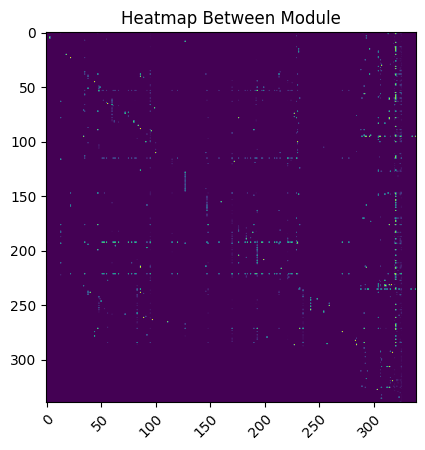

In [73]:
fig, ax = plt.subplots()
im = ax.imshow(data)

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(list(listLabel))), labels=list(listLabel))
# ax.set_yticks(np.arange(len(list(listLabel))), labels=list(listLabel))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Heatmap Between Module")

# plt.figure(figsize=(20,6))
plt.show()

In [74]:
def simName(cN1,cN2):
    def getRes(sameRoot,totalRoot):
        if totalRoot == 0:
            return 0
        else: 
            return sameRoot/totalRoot
    
    arr1 = (cN1.split("."))[ : -1]
    arr2 = (cN2.split("."))[ : -1]
    sameRoot = 0
    totalRoot = max(len(arr1),len(arr2))
    for idx in range(0,len(arr1)):
        if idx >= len(arr2):
            return getRes(sameRoot,totalRoot)
        if arr1[idx] == arr2[idx]:
            sameRoot += 1
        else:
            return getRes(sameRoot,totalRoot)
    return getRes(sameRoot,totalRoot)

In [75]:
distanceMatrix = [[0.00 for i in range(data.shape[1])] for j in range(data.shape[0])]

np.fill_diagonal(data,1) 
for i in range(0,len(data)):
    for j in range(0,i):
        distanceStructual = round(1- simStr(data[i, :], data[j, :], i, j,sum(data[:, i]), sum(data[:, j])),2)
        distanceJaccard = round(1- simJaccard(data[i, :] , data[j,:]),2)
        # distanceModul = simName(listLabel[i],listLabel[j])
        # distanceMatrix[i][j] = ((distanceStructual + distanceJaccard + distanceModul  ) / 3)
        distanceMatrix[i][j] = ((distanceStructual + distanceJaccard   ) / 2)
        distanceMatrix[j][i] = distanceMatrix[i][j]

In [76]:
distanceMatrix = np.array(distanceMatrix)

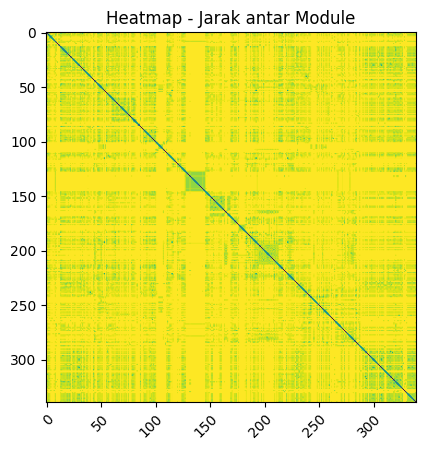

<Figure size 2000x600 with 0 Axes>

In [77]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(distanceMatrix)

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(list(listLabel))), labels=list(listLabel))
# ax.set_yticks(np.arange(len(list(listLabel))), labels=list(listLabel))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Heatmap - Jarak antar Module")

plt.figure(figsize=(20,6))
plt.show()

#### Clustering

In [78]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import cophenet,linkage

In [79]:
def calculateCluster(y,_method):
    z  =  linkage(y, method=_method)
    plt.figure(figsize=(150,8))
    # plt.figure(figsize=(10,5))
    sch.dendrogram(z,labels=listLabel)
    plt.title(f'Dendrogram {_method} Linkage')
    plt.xlabel('Module')
    plt.ylabel('Distances')
    plt.show()    
    return z

In [80]:
cDM = squareform(distanceMatrix,checks=True)

In [81]:
from scipy.spatial.distance import pdist
def evaluePDist(z):
    c, _ = cophenet(z, cDM)
    print("Cophenet  Val:",c)

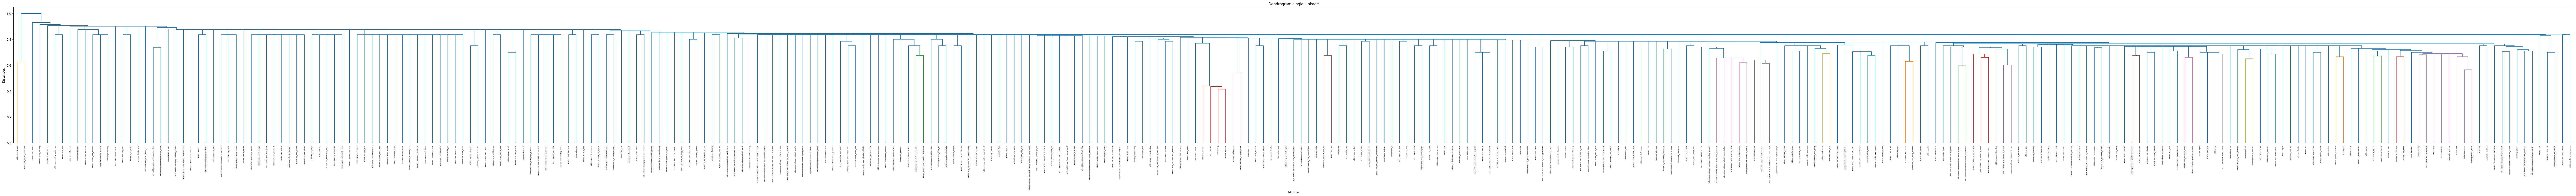

Cophenet  Val: 0.5709383488085982


In [82]:
zSingle = calculateCluster(cDM,"single")
evaluePDist(zSingle)

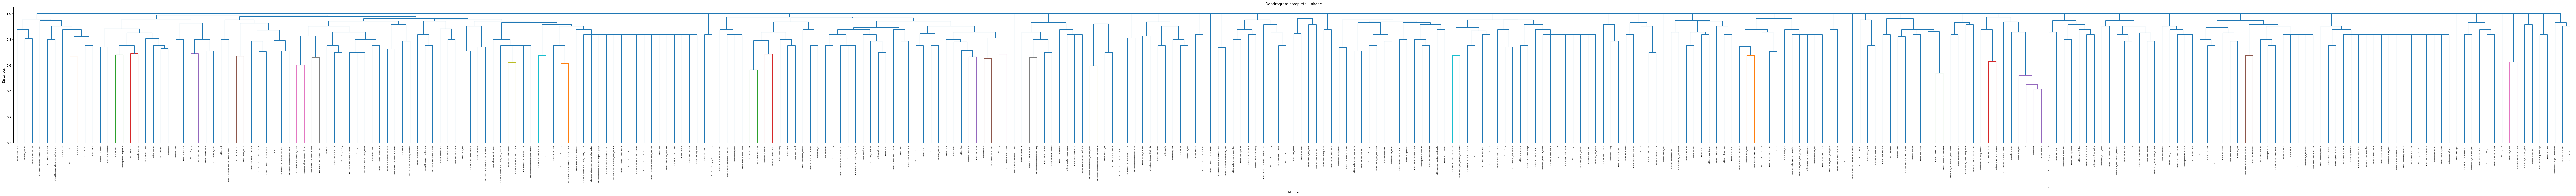

Cophenet  Val: 0.5439339038108454


In [83]:
zComplete = calculateCluster(cDM,"complete")
evaluePDist(zComplete)

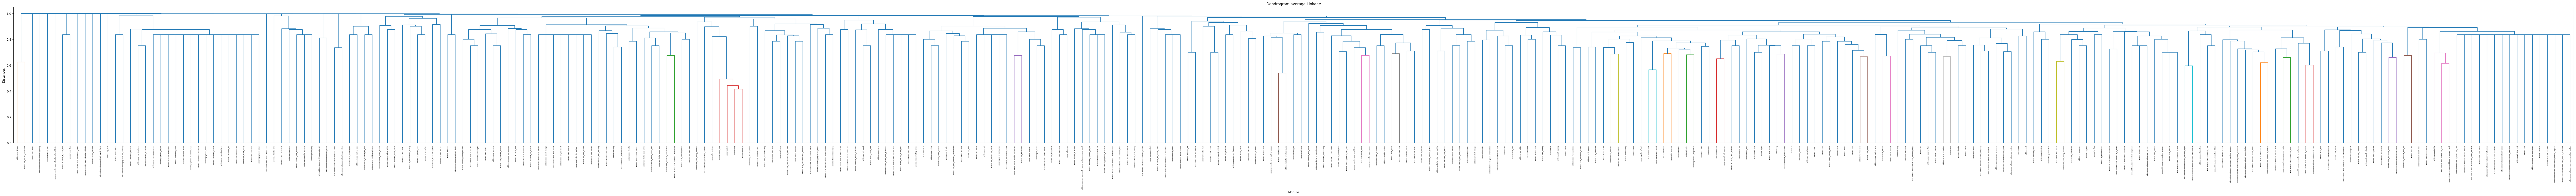

Cophenet  Val: 0.7687622032549276


In [84]:
zAverage = calculateCluster(cDM,"average")
evaluePDist(zAverage)

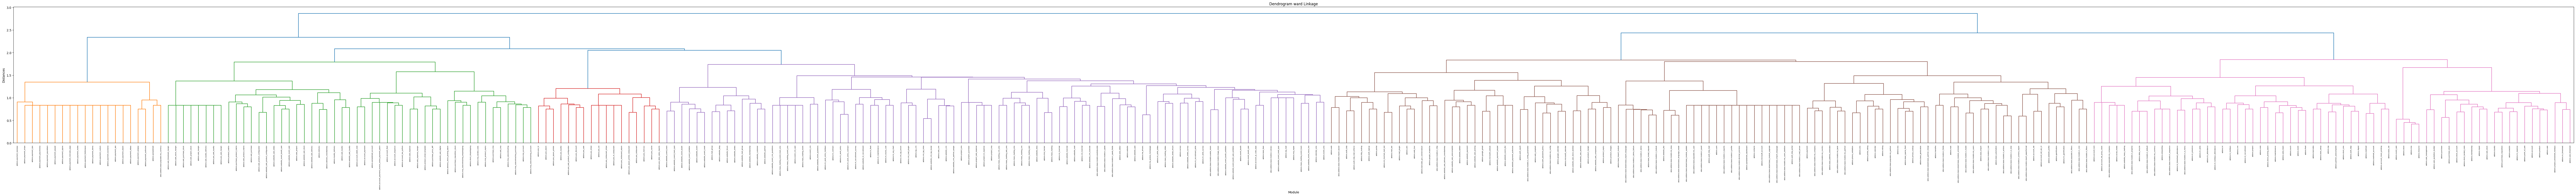

Cophenet  Val: 0.342977901321167


In [85]:
zWard = calculateCluster(cDM,"ward")
evaluePDist(zWard)

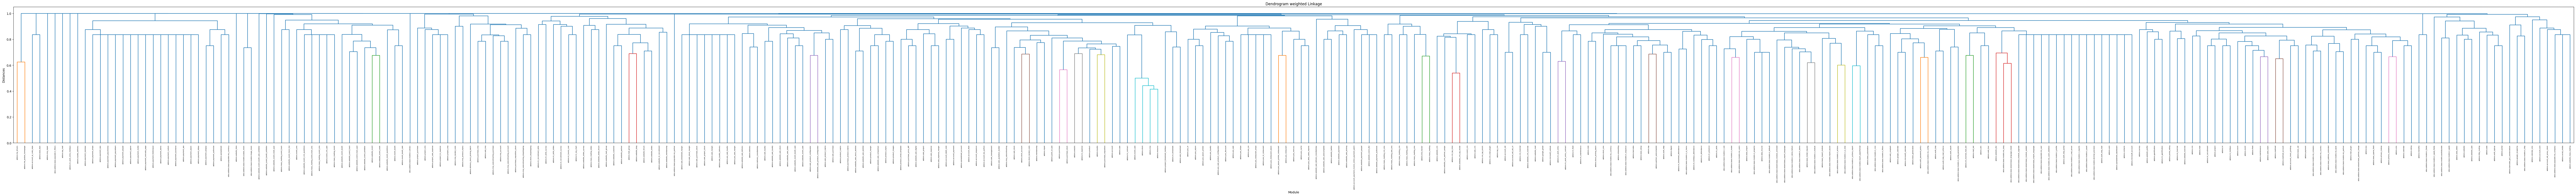

Cophenet  Val: 0.6852396505197976


In [86]:
zWeighted = calculateCluster(cDM,"weighted")
evaluePDist(zWeighted)

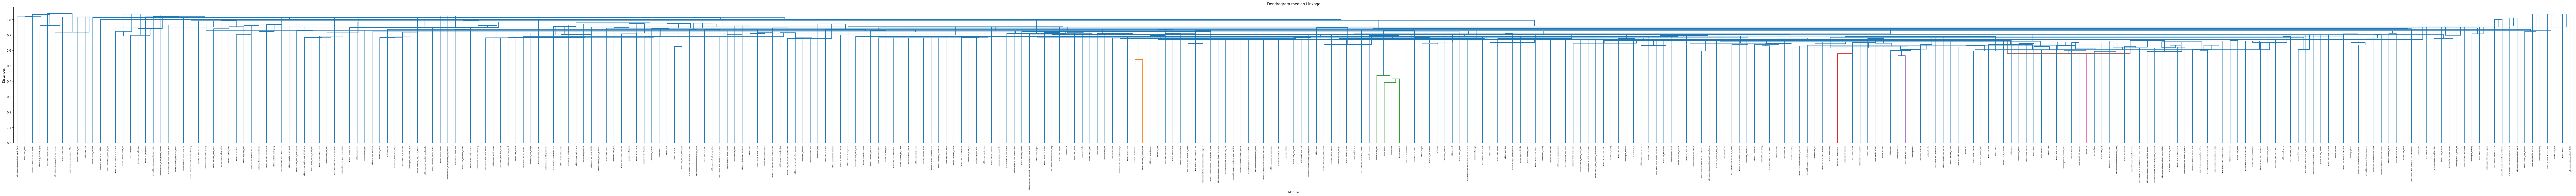

Cophenet  Val: 0.3725226046980809


In [87]:
zMedian = calculateCluster(cDM,"median")
evaluePDist(zMedian)

#### Pemilihan Cluster 

In [88]:
from scipy.cluster.hierarchy import cut_tree

In [89]:
def mergeClass(ct):
    refCall = {}
    for i in range(0,len(ct)):
        refCall[listLabel[i]] = ct[i][0]

    mergeCall = {}
    innerCallClass = {}    
    for call, cNum in refCall.items():
        if cNum not in innerCallClass:
            mergeCall[cNum] = {}
            innerCallClass[cNum] = {}
        #Inner Class Shell
        if call not in innerCallClass[cNum]:
            innerCallClass[cNum][call] = {}
        for k, w in callGraphFinal[call].items():
            #Cek apakah panggilan antar cluster
            tmpKey = k
            if refCall[k] != cNum:
                tmpKey = refCall[k]
                #Tambah di Merge untuk outside cluster call
                if refCall[k] not in mergeCall[cNum]:
                    mergeCall[cNum][refCall[k]] = 0
                mergeCall[cNum][refCall[k]] += w

            if tmpKey not in innerCallClass[cNum][call]:
                innerCallClass[cNum][call][tmpKey] = 0
            innerCallClass[cNum][call][tmpKey] += w
        
    return mergeCall, innerCallClass

In [90]:
def cutTreeToCluster(ct):
    c = {}
    for i, x in enumerate(ct):
        if x[0] not in c:
            c[x[0]] = []
        c[x[0]].append(listLabel[i])
    return c        

Based on Structural and Behavioral Dependencies:

In [91]:
def NbCalls(m,c1,c2):
    return m[c2][c1]

In [92]:
def CoupP(m, c1,c2):
    TotalNBCalls = 0
    for x in range(0,len(m)):
        if m[c1][x] > 0:
            TotalNBCalls += m[c1][x]
        if m[c2][x] > 0:
            TotalNBCalls += m[c2][x]
    if TotalNBCalls == 0:
        # print("NB Calls 0")
        return 0
    return (NbCalls(m,c1,c2) + NbCalls(m,c2,c1))/TotalNBCalls

In [93]:
def InterCoup(m):
    sumCoup = 0
    NbPossiblePairs = len(m)
    for c1 in range(0,len(m)):
        for c2 in range(0,len(m)):
          sumCoup += CoupP(m,c1,c2)
    return sumCoup/NbPossiblePairs

In [94]:
def InterCoh(rm):
    NbDirectConnections = 0
    NbPossibleConnection = 0
    #Menghitung Panggilan Internal
    for _, p in rm.items():
        if len(p) == 0:
            continue
        for m ,  call in p.items():
            #Pertibangkan Call dalam Addons
            if m in selfCG:
                NbDirectConnections += selfCG[m]
            for c, w in call.items():
                #External Call 
                if c not in p:
                    #Menghitung Panggilan External
                    NbPossibleConnection += w
                    continue 
                NbDirectConnections += w
        # adj , _ = createAdjacentMatrix(p)
        # for c1 in range(0,len(adj)):
        #     for c2 in range(0,len(adj)):
        #         NbDirectConnections += CoupP(adj,c1,c2)
    #Menghitung Panggilan External
    # for c1 in range(0,len(m)):
    #     for c2 in range(0,len(m)):
    #         NbPossibleConnection += CoupP(m,c1,c2)
    NbPossibleConnection +=  NbDirectConnections 
    return NbDirectConnections / NbPossibleConnection    
    

In [95]:
from scipy import stats as st
def modusSizeService(rm):
    sizeP = []
    for p in rm:
        sizeP.append(len(rm[p]))
    abc = np.array(sizeP)
    return (st.mode(abc,keepdims=False)).mode
    

In [96]:
def FOne(m,rm):
    interCoup = InterCoup(m)
    interCoh = InterCoh(rm)
#     modus = modusSizeService(rm)
    value = interCoh*len(m) + (1-interCoup*len(m))
    return {
            "coupling": round(interCoup,6),
            "cohesion": round(interCoh,6),
            "value": round(value, 4),
            "clusterSize": len(m)
    }

In [97]:
from multiprocessing import Process, Manager

In [98]:
ct = cut_tree(zComplete, n_clusters=2)
clusterCT = cutTreeToCluster(ct)
mgCls, inCls = mergeClass(ct)
adjMerge, _ =  createAdjacentMatrix(mgCls)

In [99]:
def checkIsSeparate(clusterCT, target):
    for c in clusterCT:
        for t in target:
            if  t in clusterCT[c] and c == 0:
                return False
            
    return True

In [100]:
def calculate_FOne(z, _n_clusters):
    ct = cut_tree(z, n_clusters=_n_clusters)
    clusterCT = cutTreeToCluster(ct)
    # if checkIsSeparate(clusterCT, [ 'addons.note']) == False:
    #     return []
    mgCls, inCls = mergeClass(ct)
    adjMerge, _ =  createAdjacentMatrix(mgCls)
    result = FOne(adjMerge,inCls)
    print(result)
    return result

Perbaiki mergeclass agar benar benar consisten

In [101]:
# ct = cut_tree(zAverage, n_clusters=2)
# clusterCT = cutTreeToCluster([[0],[0],[0],[0],[1],[0],[1]])
# mgCls, inCls = mergeClass(ct)

In [102]:
# mergeClass([[0],[0],[0],[0],[1],[0],[1]])

In [103]:
# MAX_PROCESSING = 4
# for b in range(1,len(listLabel), MAX_PROCESSING*100):
#     t = b
#     procs = []
#     print("-----------")
#     while t < b+MAX_PROCESSING*100 and t <= len(listLabel):
#         print(t)
#         t += 100
#     print("-----------")

In [104]:
def analystCluster(z):
    manager = Manager()
    dResult = manager.dict()
    MAX_PROCESSING = 4

    def target_Process(_n_clusters):
        try :
            dResult[_n_clusters] = calculate_FOne(z, _n_clusters)
        except Exception as e:
            print("Cluster: " ,_n_clusters , " E: "  ,  e)
    
    for b in range(1,len(listLabel), MAX_PROCESSING):
        t = b
        procs = []
        
        while t < b+MAX_PROCESSING and t <= len(listLabel):
            proc = Process(target=target_Process, args=(t,))
            procs.append(proc)
            proc.start()
            t+=1
        for proc in procs:
            proc.join()
    
    qualityCluster = []
    for r in  sorted(dResult):
        qualityCluster.append(dResult[r])
    return qualityCluster

In [105]:
qcSingle = analystCluster(zSingle)

{'coupling': 0.0, 'cohesion': 1.0, 'value': 2.0, 'clusterSize': 1}
{'coupling': 0.0, 'cohesion': 1.0, 'value': 3.0, 'clusterSize': 2}{'coupling': 0.666667, 'cohesion': 0.999851, 'value': 1.9996, 'clusterSize': 3}

{'coupling': 1.0, 'cohesion': 0.999702, 'value': 0.9988, 'clusterSize': 4}
{'coupling': 1.2, 'cohesion': 0.999478, 'value': -0.0026, 'clusterSize': 5}
{'coupling': 1.333333, 'cohesion': 0.999329, 'value': -1.004, 'clusterSize': 6}
{'coupling': 1.428571, 'cohesion': 0.999254, 'value': -2.0052, 'clusterSize': 7}
{'coupling': 1.5, 'cohesion': 0.998434, 'value': -3.0125, 'clusterSize': 8}
{'coupling': 1.555556, 'cohesion': 0.998285, 'value': -4.0154, 'clusterSize': 9}
{'coupling': 1.6, 'cohesion': 0.997837, 'value': -5.0216, 'clusterSize': 10}
{'coupling': 1.666667, 'cohesion': 0.99739, 'value': -7.0313, 'clusterSize': 12}
{'coupling': 1.636364, 'cohesion': 0.997539, 'value': -6.0271, 'clusterSize': 11}
{'coupling': 0.490224, 'cohesion': 0.996196, 'value': 7.5776, 'clusterSize': 

In [106]:
qcComplete = analystCluster(zComplete)

{'coupling': 0.0, 'cohesion': 1.0, 'value': 2.0, 'clusterSize': 1}
{'coupling': 0.846559, 'cohesion': 0.795943, 'value': 0.8482, 'clusterSize': 3}
{'coupling': 1.0, 'cohesion': 0.981727, 'value': 0.9635, 'clusterSize': 2}
{'coupling': 0.637492, 'cohesion': 0.795719, 'value': 1.6329, 'clusterSize': 4}
{'coupling': 0.667998, 'cohesion': 0.747837, 'value': 1.3992, 'clusterSize': 5}
{'coupling': 0.556853, 'cohesion': 0.747837, 'value': 2.1459, 'clusterSize': 6}
{'coupling': 0.735385, 'cohesion': 0.7456, 'value': 1.0715, 'clusterSize': 7}
{'coupling': 0.710637, 'cohesion': 0.74545, 'value': 1.2785, 'clusterSize': 8}
{'coupling': 0.701525, 'cohesion': 0.744332, 'value': 1.3853, 'clusterSize': 9}
{'coupling': 0.718623, 'cohesion': 0.744033, 'value': 1.2541, 'clusterSize': 10}
{'coupling': 0.798625, 'cohesion': 0.741647, 'value': 0.3732, 'clusterSize': 11}
{'coupling': 0.732062, 'cohesion': 0.741647, 'value': 1.115, 'clusterSize': 12}
{'coupling': 0.678015, 'cohesion': 0.741647, 'value': 1.827

In [107]:
qcAverage = analystCluster(zAverage)

{'coupling': 0.0, 'cohesion': 1.0, 'value': 2.0, 'clusterSize': 1}
{'coupling': 0.666667, 'cohesion': 0.999851, 'value': 1.9996, 'clusterSize': 3}
{'coupling': 0.0, 'cohesion': 1.0, 'value': 3.0, 'clusterSize': 2}
{'coupling': 0.75, 'cohesion': 0.999776, 'value': 1.9991, 'clusterSize': 4}
{'coupling': 0.733333, 'cohesion': 0.999702, 'value': 2.3318, 'clusterSize': 5}
{'coupling': 0.75, 'cohesion': 0.999403, 'value': 2.9952, 'clusterSize': 8}
{'coupling': 0.761905, 'cohesion': 0.999478, 'value': 2.663, 'clusterSize': 7}
{'coupling': 0.722222, 'cohesion': 0.999627, 'value': 2.6644, 'clusterSize': 6}
{'coupling': 0.614815, 'cohesion': 0.999105, 'value': 4.4586, 'clusterSize': 9}
{'coupling': 0.62, 'cohesion': 0.998956, 'value': 4.7896, 'clusterSize': 10}
{'coupling': 0.412121, 'cohesion': 0.997315, 'value': 7.4371, 'clusterSize': 11}
{'coupling': 0.396296, 'cohesion': 0.99724, 'value': 8.2113, 'clusterSize': 12}
{'coupling': 0.213945, 'cohesion': 0.988216, 'value': 11.0655, 'clusterSize':

In [108]:
qcWard = analystCluster(zWard)

{'coupling': 0.948364, 'cohesion': 0.748807, 'value': 0.4013, 'clusterSize': 3}
{'coupling': 0.0, 'cohesion': 1.0, 'value': 2.0, 'clusterSize': 1}
{'coupling': 1.0, 'cohesion': 0.869332, 'value': 0.7387, 'clusterSize': 2}
{'coupling': 0.86075, 'cohesion': 0.748807, 'value': 0.5522, 'clusterSize': 4}
{'coupling': 0.747013, 'cohesion': 0.74724, 'value': 1.0011, 'clusterSize': 5}
{'coupling': 0.647551, 'cohesion': 0.74724, 'value': 1.5981, 'clusterSize': 6}
{'coupling': 0.84042, 'cohesion': 0.720689, 'value': 0.1619, 'clusterSize': 7}
{'coupling': 0.939628, 'cohesion': 0.711068, 'value': -0.8285, 'clusterSize': 8}
{'coupling': 0.907022, 'cohesion': 0.704654, 'value': -0.8213, 'clusterSize': 9}
{'coupling': 0.810267, 'cohesion': 0.704654, 'value': -0.0561, 'clusterSize': 10}
{'coupling': 0.951731, 'cohesion': 0.659457, 'value': -2.5073, 'clusterSize': 12}
{'coupling': 0.876146, 'cohesion': 0.698389, 'value': -0.9553, 'clusterSize': 11}
{'coupling': 0.885561, 'cohesion': 0.659457, 'value': 

In [ ]:
# qcMedian = analystCluster(zMedian)

In [ ]:
# qcWeighted= analystCluster(zWeighted)

In [ ]:
import matplotlib.pyplot as plt
def visualizeQualityCluster(qualityCluster,linkageType):
    def getAsListResult(qualityCluster):
        clusterSizeIter = []
        couplingIter = []
        cohesionIter =[]
        for v in qualityCluster:
            clusterSizeIter.append( v['clusterSize'])
            couplingIter.append( v['coupling'])
            cohesionIter.append( v['cohesion'])
        return clusterSizeIter, couplingIter, cohesionIter
    clusterSizeIter, couplingIter, cohesionIter  = getAsListResult(qualityCluster) 

    plt.plot(clusterSizeIter, couplingIter , label ='Coupling')
    plt.plot(clusterSizeIter, cohesionIter  , label ='Cohesion')

    plt.xlabel("Jumlah Partisi/Cluster")
    plt.ylabel("Coupling x Cohesion")
    plt.legend()
    plt.title(f'Perbandingan Coupling & Cohesion dengan Jumlah Cluster ({linkageType})')
    plt.show()


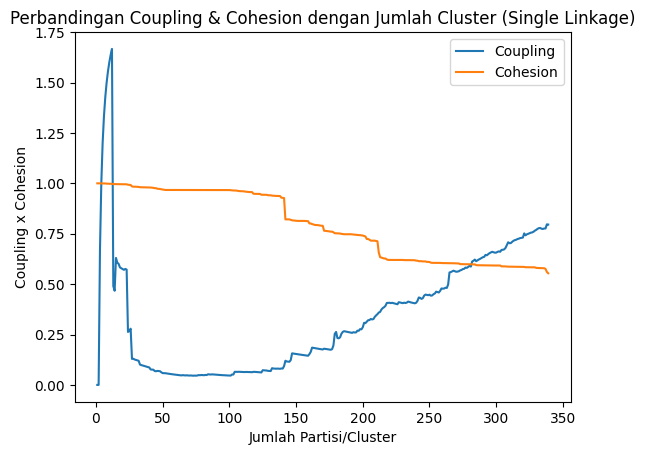

In [ ]:
visualizeQualityCluster(qcSingle,"Single Linkage")

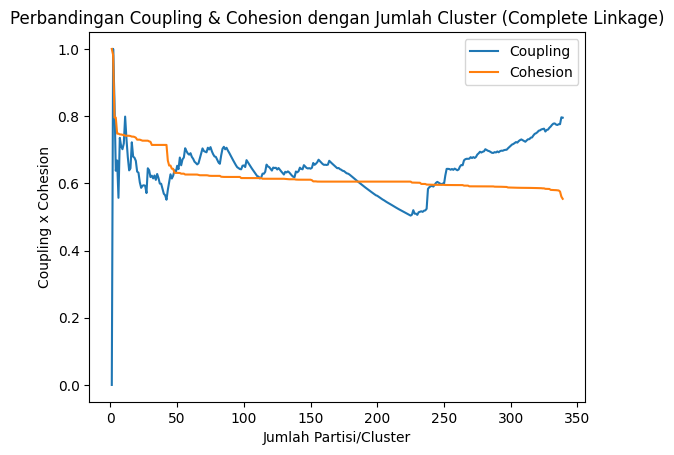

In [ ]:
visualizeQualityCluster(qcComplete,"Complete Linkage")

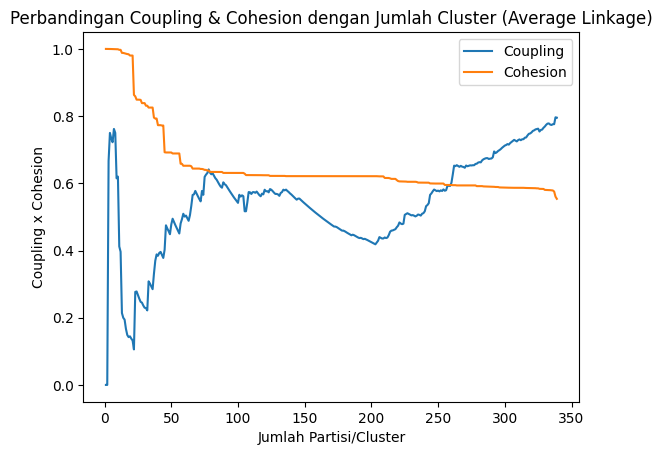

In [ ]:
visualizeQualityCluster(qcAverage,"Average Linkage")

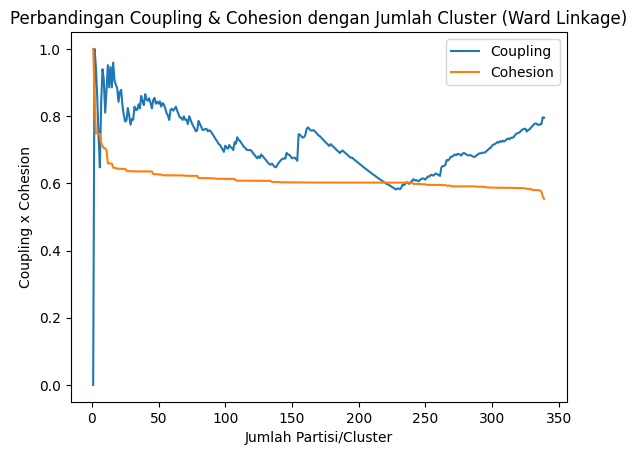

In [ ]:
visualizeQualityCluster(qcWard,"Ward Linkage")

In [ ]:
# visualizeQualityCluster(qcWeighted, "Weighted Linkage")

In [ ]:
# visualizeQualityCluster(qcMedian, "Median Linkage")

#### Pemilihan Jumlah Cluster Terbaik

In [ ]:
def pilihMaxVal(qc,label):
    maxVal = {'value':None , 'clusterSize' : len(listLabel)}
    for c in qc:
        if maxVal['value'] == None:
            maxVal = c
        if c['value'] >= maxVal['value']  :
            maxVal = c
    print(f'Linkage Method: {label} \nJumlah Cluster terbaik: {maxVal["clusterSize"]} service/partisi \nDetail:',  maxVal)

In [ ]:
pilihMaxVal(qcSingle,"Single")

Linkage Method: Single 
Jumlah Cluster terbaik: 140 service/partisi 
Detail: {'coupling': 0.081095, 'cohesion': 0.927879, 'value': 119.5497, 'clusterSize': 140}


In [ ]:
pilihMaxVal(qcComplete,"Complete")

Linkage Method: Complete 
Jumlah Cluster terbaik: 225 service/partisi 
Detail: {'coupling': 0.503931, 'cohesion': 0.605087, 'value': 23.7599, 'clusterSize': 225}


In [ ]:
pilihMaxVal(qcAverage,"Average")

Linkage Method: Average 
Jumlah Cluster terbaik: 203 service/partisi 
Detail: {'coupling': 0.418473, 'cohesion': 0.62142, 'value': 42.1983, 'clusterSize': 203}


In [ ]:
pilihMaxVal(qcWard, "Ward")

Linkage Method: Ward 
Jumlah Cluster terbaik: 228 service/partisi 
Detail: {'coupling': 0.58156, 'cohesion': 0.602252, 'value': 5.7178, 'clusterSize': 228}


In [ ]:
# pilihMaxVal(qcWeighted, "Weighted")

In [ ]:
# pilihMaxVal(qcMedian, "Median")

Pembagian service dengan modules-nya

In [ ]:
def debugCluster(z,size):
    ct = cut_tree(z, n_clusters=size)
    clusterCT = cutTreeToCluster(ct)
    mgCls, inCls = mergeClass(ct)
    adjMerge, _ =  createAdjacentMatrix(mgCls)
    # print(clusterCT)
    return clusterCT
    
debugCluster(zAverage,226)

{0: ['addons.account',
  'addons.analytic',
  'addons.hr_expense',
  'addons.loyalty',
  'addons.product',
  'addons.purchase',
  'addons.purchase_requisition',
  'addons.purchase_stock',
  'addons.sale'],
 1: ['addons.account_check_printing',
  'addons.base_vat',
  'addons.snailmail',
  'addons.snailmail_account'],
 2: ['addons.account_debit_note', 'addons.account_payment'],
 3: ['addons.account_edi', 'addons.account_edi_ubl_cii'],
 4: ['addons.account_edi_proxy_client'],
 5: ['addons.account_fleet'],
 6: ['addons.account_lock'],
 7: ['addons.account_payment_invoice_online_payment_patch'],
 8: ['addons.account_qr_code_sepa'],
 9: ['addons.account_sequence'],
 10: ['addons.account_tax_python'],
 11: ['addons.auth_ldap',
  'addons.base_setup',
  'addons.digest',
  'addons.iap',
  'addons.partner_autocomplete'],
 12: ['addons.auth_oauth', 'odoo.addons.base.models.ir_config_parameter'],
 13: ['addons.auth_password_policy',
  'addons.base_geolocalize',
  'addons.website_twitter',
  'odoo.a